In [30]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [31]:
# Get current working directory
import os
cwd = os.getcwd()
print("Current working directory:", cwd)
os.chdir("n:/Incubator2025_ComputationalLifeCourse")

Current working directory: n:\Incubator2025_ComputationalLifeCourse


In [32]:
import sys
sys.path.append("Scripts/g_comp")  # relative path from your current working directory
import g_comp as gc

In [33]:
# Reload the module (if it's been edited and needs to be reloaded)
import importlib
importlib.reload(gc)

<module 'g_comp' from 'n:\\Incubator2025_ComputationalLifeCourse\\Scripts/g_comp\\g_comp.py'>

In [34]:
def set_seed(seed =42):
    """Set seed for reproducibility across multiple libraries"""
    random.seed(seed)  # Python's built-in random
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed_all(seed)  # PyTorch CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2025)  # Call this at the beginning of your code

In [35]:
## Load the data 
import pandas as pd
df = pd.read_csv("Data/Processed/g_data.csv")
df = df.sort_values(["mergeid", "t_age"]) 

In [36]:
## Check the number of dropped cases 
complete_y_cogn_65_75_dic_mergeids = gc.summarize_mergeid_completeness(df, ["y_cogn_65_75_dic", "dt_n_years_disease_dic"], "cogn 65–75")

[cogn 65–75]
Original mergeids: 20806
Complete mergeids (no missing values in Y): 14452
Number of unique mergeids dropped: 6354



In [37]:
###############
## Data prep ##
###############

# N = number of individuals, T = number of time points (i.e., 33)
# Generate datasets for pooled and by regime 
T = 33
df_cogn_65_75 = gc.get_valid_df(df, complete_y_cogn_65_75_dic_mergeids, "cogn 65–75", T)
df_cogn_med_65_75 = df_cogn_65_75[df_cogn_65_75["mod_welfare_regime_mediterranean"] == 1.0]
df_cogn_cor_65_75 = df_cogn_65_75[df_cogn_65_75["mod_welfare_regime_corporatist"] == 1.0]
df_cogn_scan_65_75 = df_cogn_65_75[df_cogn_65_75["mod_welfare_regime_scandinavian"] == 1.0]
 

# Mediterranean 
feature_cols_outcome_med_65_75 = gc.get_feature_cols(df_cogn_med_65_75, context="outcome and med")
feature_cols_tv_covar_med_65_75 = gc.get_feature_cols(df_cogn_med_65_75, context="tv_covar and med")

# Corporatist
feature_cols_outcome_cor_65_75 = gc.get_feature_cols(df_cogn_cor_65_75, context="outcome and cor")
feature_cols_tv_covar_cor_65_75 = gc.get_feature_cols(df_cogn_cor_65_75, context="tv_covar and cor")

# Scandinavian
feature_cols_outcome_scan_65_75 = gc.get_feature_cols(df_cogn_scan_65_75, context="outcome and scan")
feature_cols_tv_covar_scan_65_75 = gc.get_feature_cols(df_cogn_scan_65_75, context="tv_covar and scan")


# Convert to (N, T, D) tensor
# Treatment and covariates from the dataset 
 
# Mediterranean 
N_cogn_med_65_75 = df_cogn_med_65_75['mergeid'].nunique()
X_cogn_med_65_75 = gc.convert_df_to_X(df_cogn_med_65_75, feature_cols_outcome_med_65_75, N_cogn_med_65_75, T)
X_disease_med_65_75  = gc.convert_df_to_X(df_cogn_med_65_75, feature_cols_tv_covar_med_65_75, N_cogn_med_65_75, T)

# Corporatist
N_cogn_cor_65_75 = df_cogn_cor_65_75['mergeid'].nunique()
X_cogn_cor_65_75 = gc.convert_df_to_X(df_cogn_cor_65_75, feature_cols_outcome_cor_65_75, N_cogn_cor_65_75, T)
X_disease_cor_65_75  = gc.convert_df_to_X(df_cogn_cor_65_75, feature_cols_tv_covar_cor_65_75, N_cogn_cor_65_75, T)

# Scandinavian
N_cogn_scan_65_75 = df_cogn_scan_65_75['mergeid'].nunique()
X_cogn_scan_65_75 = gc.convert_df_to_X(df_cogn_scan_65_75, feature_cols_outcome_scan_65_75, N_cogn_scan_65_75, T)
X_disease_scan_65_75  = gc.convert_df_to_X(df_cogn_scan_65_75, feature_cols_tv_covar_scan_65_75, N_cogn_scan_65_75, T)

[cogn 65–75]
Mergeids with complete outcome and 33 unique ages: 14452
[get_feature_cols] Context: outcome and med | Exclude: ['mod_country_italy']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and med | Exclude: ['mod_country_italy', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded
[get_feature_cols] Context: outcome and cor | Exclude: ['mod_country_germany']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and cor | Exclude: ['mod_country_germany', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded
[get_feature_cols] Context: outcome and scan | Exclude: ['mod_country_sweden']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and scan | Exclude: ['mod_country_sweden', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded


In [38]:
###############
## Y and L_t ##
###############

# Binary outcomes  
y_cogn_med_65_75_dic = gc.extract_y_tensor(df_cogn_med_65_75, "y_cogn_65_75_dic")
y_cogn_cor_65_75_dic = gc.extract_y_tensor(df_cogn_cor_65_75, "y_cogn_65_75_dic")
y_cogn_scan_65_75_dic = gc.extract_y_tensor(df_cogn_scan_65_75, "y_cogn_65_75_dic")

# Binary outcomes for tv covar 
# Mediterranean 
y_disease_med_65_75_dic = gc.extract_y_tensor(df_cogn_med_65_75, "dt_n_years_disease_dic")
y_disease_cor_65_75_dic = gc.extract_y_tensor(df_cogn_cor_65_75, "dt_n_years_disease_dic")
y_disease_scan_65_75_dic = gc.extract_y_tensor(df_cogn_scan_65_75, "dt_n_years_disease_dic")

In [39]:
#####################
## \vec{a} and L_0 ##
#####################

# Extract high-level treatment trajectory features with covariates for each X matrix
# Mediterranean
X_med_features_cogn_65_75_dic = gc.extract_features(X_cogn_med_65_75, feature_cols_outcome_med_65_75)
X_med_features_disease_65_75_dic  = gc.extract_features(X_disease_med_65_75, feature_cols_tv_covar_med_65_75)

# Corporatist
X_cor_features_cogn_65_75_dic = gc.extract_features(X_cogn_cor_65_75, feature_cols_outcome_cor_65_75)
X_cor_features_disease_65_75_dic  = gc.extract_features(X_disease_cor_65_75, feature_cols_tv_covar_cor_65_75)

# Scandinavian
X_scan_features_cogn_65_75_dic = gc.extract_features(X_cogn_scan_65_75, feature_cols_outcome_scan_65_75)
X_scan_features_disease_65_75_dic  = gc.extract_features(X_disease_scan_65_75, feature_cols_tv_covar_scan_65_75)



# Feature Names
trt_features_med_cogn_65_75_dic   = gc.create_feature_df(X_med_features_cogn_65_75_dic, feature_cols_outcome_med_65_75, "cogn 65–75")
trt_features_cor_cogn_65_75_dic   = gc.create_feature_df(X_cor_features_cogn_65_75_dic, feature_cols_outcome_cor_65_75, "cogn 65–75")
trt_features_scan_cogn_65_75_dic   = gc.create_feature_df(X_scan_features_cogn_65_75_dic, feature_cols_outcome_scan_65_75, "cogn 65–75")


cogn 65–75: Feature dataframe shape = (4523, 48)
cogn 65–75: Feature dataframe shape = (7208, 48)
cogn 65–75: Feature dataframe shape = (2721, 48)


In [40]:
################### 
## Linear models ##
#################### 

y_cogn_med_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_med_features_cogn_65_75_dic, y_cogn_med_65_75_dic, "cogn 65–75 (med, logistic)", save_dir="model_outputs/cogn/med")
y_disease_med_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_med_features_disease_65_75_dic, y_disease_med_65_75_dic, "disease 65–75 (med, logistic)", save_dir="model_outputs/cogn/med")

y_cogn_cor_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_cor_features_cogn_65_75_dic, y_cogn_cor_65_75_dic, "cogn 65–75 (cor, logistic)", save_dir="model_outputs/cogn/cor")
y_disease_cor_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_cor_features_disease_65_75_dic, y_disease_cor_65_75_dic, "disease 65–75 (cor, logistic)", save_dir="model_outputs/cogn/cor")

y_cogn_scan_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_scan_features_cogn_65_75_dic, y_cogn_scan_65_75_dic, "cogn 65–75 (scan, logistic)", save_dir="model_outputs/cogn/scan")
y_disease_scan_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_scan_features_disease_65_75_dic, y_disease_scan_65_75_dic, "disease 65–75 (scan, logistic)", save_dir="model_outputs/cogn/scan")


=== cogn 65–75 (med, logistic) ===
Train Accuracy: 0.6756159191408717
Test Accuracy: 0.6624907885040531
Test AUC: 0.7203863301434514

=== disease 65–75 (med, logistic) ===
Train Accuracy: 0.6099178774478837
Test Accuracy: 0.5350036845983788
Test AUC: 0.5589702043388244

=== cogn 65–75 (cor, logistic) ===
Train Accuracy: 0.7268582755203171
Test Accuracy: 0.723994452149792
Test AUC: 0.8195309123614404

=== disease 65–75 (cor, logistic) ===
Train Accuracy: 0.6095143706640238
Test Accuracy: 0.6047156726768377
Test AUC: 0.6121488328305197

=== cogn 65–75 (scan, logistic) ===
Train Accuracy: 0.7510504201680672
Test Accuracy: 0.7062423500611995
Test AUC: 0.657241428368189

=== disease 65–75 (scan, logistic) ===
Train Accuracy: 0.6649159663865546
Test Accuracy: 0.6266829865361077
Test AUC: 0.6329892148222754


In [41]:
# Logistic regression coefficients 
y_cogn_med_65_75_logistic_coef_summary = gc.logistic_coef_summary(
    y_cogn_med_65_75_dic_logistic,
    trt_features_med_cogn_65_75_dic,
    y_cogn_med_65_75_dic,
    label="y_cogn_med_65_75_dic_logistic",   # this will be used for the file name
    save_dir="model_outputs/cogn/med"
)

y_cogn_cor_65_75_logistic_coef_summary = gc.logistic_coef_summary(
    y_cogn_cor_65_75_dic_logistic,
    trt_features_cor_cogn_65_75_dic,
    y_cogn_med_65_75_dic,
    label="y_cogn_cor_65_75_dic_logistic",   # this will be used for the file name
    save_dir="model_outputs/cogn/cor"
)

y_cogn_scan_65_75_logistic_coef_summary = gc.logistic_coef_summary(
    y_cogn_scan_65_75_dic_logistic,
    trt_features_scan_cogn_65_75_dic,
    y_cogn_scan_65_75_dic,
    label="y_cogn_scan_65_75_dic_logistic",   # this will be used for the file name
    save_dir="model_outputs/cogn/scan"
)

print(y_cogn_med_65_75_logistic_coef_summary)
print(y_cogn_cor_65_75_logistic_coef_summary)
print(y_cogn_scan_65_75_logistic_coef_summary)

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
n:\Incubator2025_ComputationalLifeCourse\Scripts/g_comp\g_comp.py:542: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov_logit))
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


✅ Saved coefficient summary to: model_outputs/cogn/med\y_cogn_med_65_75_dic_logistic_coef_summary.csv
✅ Saved coefficient summary to: model_outputs/cogn/cor\y_cogn_cor_65_75_dic_logistic_coef_summary.csv
✅ Saved coefficient summary to: model_outputs/cogn/scan\y_cogn_scan_65_75_dic_logistic_coef_summary.csv
                      feature      coef  odds_ratio  std_error    z_value  \
0                   Intercept -0.123341    0.883962   0.280710  -0.439389   
1               cum_full_time  0.007475    1.007503   0.140501   0.053200   
2               cum_part_time  0.187495    1.206224   0.098155   1.910193   
3                 years_cohab -0.133840    0.874730        NaN        NaN   
4             years_not_cohab  0.133840    1.143210        NaN        NaN   
5         years_with_children  0.027035    1.027404        NaN        NaN   
6      years_without_children -0.027035    0.973327        NaN        NaN   
7     dominant_work_full_time -0.029127    0.971293        NaN        NaN   

n:\Incubator2025_ComputationalLifeCourse\Scripts/g_comp\g_comp.py:542: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov_logit))
n:\Incubator2025_ComputationalLifeCourse\Scripts/g_comp\g_comp.py:545: RuntimeWarning: divide by zero encountered in divide
  z_vals = coefs / se
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
n:\Incubator2025_ComputationalLifeCourse\Scripts/g_comp\g_comp.py:542: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov_logit))


In [42]:
############################
## Tuning for best models ##
############################
# Best models for med sample 
y_cogn_med_65_75_dic_model, y_cogn_med_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_med_features_cogn_65_75_dic, y_cogn_med_65_75_dic, "cogn 65–75 (med)", save_dir="model_outputs/cogn/med")
y_disease_med_65_75_dic_model, y_disease_med_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_med_features_disease_65_75_dic, y_disease_med_65_75_dic, "disease 65–75 (med)", save_dir="model_outputs/cogn/med")

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:36:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:1


=== cogn 65–75 (med) ===
Train Accuracy: 0.6951989892608971
Test Accuracy: 0.6529108327192336
Test AUC: 0.7213750069953553


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_


=== disease 65–75 (med) ===
Train Accuracy: 0.6162349968414403
Test Accuracy: 0.5320560058953574
Test AUC: 0.5781588501815345


In [43]:
# Best models for cor sample 
y_cogn_cor_65_75_dic_model, y_cogn_cor_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_cor_features_cogn_65_75_dic, y_cogn_cor_65_75_dic, "cogn 65–75 (cor)", save_dir="model_outputs/cogn/cor")
y_disease_cor_65_75_dic_model, y_disease_cor_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_cor_features_disease_65_75_dic, y_disease_cor_65_75_dic, "disease 65–75 (cor)", save_dir="model_outputs/cogn/cor")

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:40:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:40:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\


=== cogn 65–75 (cor) ===
Train Accuracy: 0.7230921704658078
Test Accuracy: 0.713823393435044
Test AUC: 0.8269801315220819


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:41:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:41:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:41:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:41:00] WARNING: C:\actions-r


=== disease 65–75 (cor) ===
Train Accuracy: 0.6241823587710604
Test Accuracy: 0.5899214054553861
Test AUC: 0.6142898025119284


In [44]:
# Best models for scan sample 
y_cogn_scan_65_75_dic_model, y_cogn_scan_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_scan_features_cogn_65_75_dic, y_cogn_scan_65_75_dic, "cogn 65–75 (scan)", save_dir="model_outputs/cogn/scan")
y_disease_scan_65_75_dic_model, y_disease_scan_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_scan_features_disease_65_75_dic, y_disease_scan_65_75_dic, "disease 65–75 (scan)", save_dir="model_outputs/cogn/scan")

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_


=== cogn 65–75 (scan) ===
Train Accuracy: 0.7216386554621849
Test Accuracy: 0.6401468788249693
Test AUC: 0.7396500213401622


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_


=== disease 65–75 (scan) ===
Train Accuracy: 0.7872899159663865
Test Accuracy: 0.6254589963280294
Test AUC: 0.6360002517940325


In [45]:
#############################
## Counterfactual analysis ## 
#############################

import pandas as pd
medoid_df = pd.read_csv("Data/Processed/medoid_seq_data.csv")
# Your custom emodid order
custom_order = ['AT-148850-02', 'GR-336206-02', 'Bn-067069-02', 'IT-813620-01']

# Reorder DataFrame based on this order
medoid_df = medoid_df.sort_values(["mergeid", "t_age"]) 
medoid_df = medoid_df.set_index('mergeid').loc[custom_order].reset_index()

N_medoid = medoid_df['mergeid'].nunique()
X_medoid_cogn_65_75_dic   = gc.convert_df_to_X(medoid_df, feature_cols_outcome_med_65_75, N_medoid, T)
X_medoid_disease_65_75_dic  = gc.convert_df_to_X(medoid_df, feature_cols_tv_covar_med_65_75, N_medoid, T)
X_medoid_features_65_75_dic   = gc.extract_treatment_features_from_medoid(X_medoid_cogn_65_75_dic, feature_cols_outcome_med_65_75) 

In [46]:
#######################################################
## Counterfactual analysis : No cohabit and No child ## 
#######################################################

import pandas as pd
medoid_no_cohabit_no_child_df = pd.read_csv("Data/Processed/medoid_seq_data_no_cohabit_no_child.csv")
# Your custom emodid order
custom_order = ['AT-148850-02', 'GR-336206-02', 'Bn-067069-02', 'IT-813620-01']

# Reorder DataFrame based on this order
medoid_no_cohabit_no_child_df = medoid_no_cohabit_no_child_df.sort_values(["mergeid", "t_age"]) 
medoid_no_cohabit_no_child_df = medoid_no_cohabit_no_child_df.set_index('mergeid').loc[custom_order].reset_index()

N_medoid_no_cohabit_no_child = medoid_no_cohabit_no_child_df['mergeid'].nunique()
X_medoid_no_cohabit_no_child_cogn_65_75_dic   = gc.convert_df_to_X(medoid_no_cohabit_no_child_df, feature_cols_outcome_med_65_75, N_medoid_no_cohabit_no_child, T)
X_medoid_no_cohabit_no_child_disease_65_75_dic  = gc.convert_df_to_X(medoid_no_cohabit_no_child_df, feature_cols_tv_covar_med_65_75, N_medoid_no_cohabit_no_child, T)
X_medoid_no_cohabit_no_child_features_65_75_dic   = gc.extract_treatment_features_from_medoid(X_medoid_no_cohabit_no_child_cogn_65_75_dic, feature_cols_outcome_med_65_75) 

In [47]:
#######################################################
## Counterfactual analysis : No cohabit and With child ## 
#######################################################

import pandas as pd
medoid_no_cohabit_with_child_df = pd.read_csv("Data/Processed/medoid_seq_data_no_cohabit_with_child.csv")
# Your custom emodid order
custom_order = ['AT-148850-02', 'GR-336206-02', 'Bn-067069-02', 'IT-813620-01']
 
# Reorder DataFrame based on this order
medoid_no_cohabit_with_child_df = medoid_no_cohabit_with_child_df.sort_values(["mergeid", "t_age"]) 
medoid_no_cohabit_with_child_df = medoid_no_cohabit_with_child_df.set_index('mergeid').loc[custom_order].reset_index()

N_medoid_no_cohabit_with_child = medoid_no_cohabit_with_child_df['mergeid'].nunique()
X_medoid_no_cohabit_with_child_cogn_65_75_dic   = gc.convert_df_to_X(medoid_no_cohabit_with_child_df, feature_cols_outcome_med_65_75, N_medoid_no_cohabit_with_child, T)
X_medoid_no_cohabit_with_child_disease_65_75_dic  = gc.convert_df_to_X(medoid_no_cohabit_with_child_df, feature_cols_tv_covar_med_65_75, N_medoid_no_cohabit_with_child, T)
X_medoid_no_cohabit_with_child_features_65_75_dic   = gc.extract_treatment_features_from_medoid(X_medoid_no_cohabit_with_child_cogn_65_75_dic, feature_cols_outcome_med_65_75) 

In [48]:
###########################################
## Hypothetical intervention with medoid ##
###########################################

# Mediterranean regime
X_features_disease_med_65_75_dic_updated_list = gc.generate_updated_list(
    X_med_features_disease_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

X_features_cogn_med_65_75_dic_updated_list = gc.generate_updated_list(
    X_med_features_cogn_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

# Corporatist regime
X_cor_features_disease_65_75_dic_updated_list = gc.generate_updated_list(
    X_cor_features_disease_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

X_cor_features_cogn_65_75_dic_updated_list = gc.generate_updated_list(
    X_cor_features_cogn_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

# Scandinavian regime
X_scan_features_disease_65_75_dic_updated_list = gc.generate_updated_list(
    X_scan_features_disease_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

X_scan_features_cogn_65_75_dic_updated_list = gc.generate_updated_list(
    X_scan_features_cogn_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

 

In [49]:
##################################################################### 
## Hypothetical intervention with medoid : No cohabit and No child ## 
##################################################################### 

# Mediterranean regime
X_features_no_cohabit_no_child_disease_med_65_75_dic_updated_list = gc.generate_updated_list(
    X_med_features_disease_65_75_dic, X_medoid_no_cohabit_no_child_features_65_75_dic, cols_to_replace=30)

X_features_no_cohabit_no_child_cogn_med_65_75_dic_updated_list = gc.generate_updated_list(
    X_med_features_cogn_65_75_dic, X_medoid_no_cohabit_no_child_features_65_75_dic, cols_to_replace=30)

# Corporatist regime
X_cor_features_no_cohabit_no_child_disease_65_75_dic_updated_list = gc.generate_updated_list(
    X_cor_features_disease_65_75_dic, X_medoid_no_cohabit_no_child_features_65_75_dic, cols_to_replace=30)

X_cor_features_no_cohabit_no_child_cogn_65_75_dic_updated_list = gc.generate_updated_list(
    X_cor_features_cogn_65_75_dic, X_medoid_no_cohabit_no_child_features_65_75_dic, cols_to_replace=30)

# Scandinavian regime
X_scan_features_no_cohabit_no_child_disease_65_75_dic_updated_list = gc.generate_updated_list(
    X_scan_features_disease_65_75_dic, X_medoid_no_cohabit_no_child_features_65_75_dic, cols_to_replace=30)

X_scan_features_no_cohabit_no_child_cogn_65_75_dic_updated_list = gc.generate_updated_list(
    X_scan_features_cogn_65_75_dic, X_medoid_no_cohabit_no_child_features_65_75_dic, cols_to_replace=30)


In [50]:
####################################################################### 
## Hypothetical intervention with medoid : No cohabit and With child ## 
####################################################################### 

# Mediterranean regime
X_features_no_cohabit_with_child_disease_med_65_75_dic_updated_list = gc.generate_updated_list(
    X_med_features_disease_65_75_dic, X_medoid_no_cohabit_with_child_features_65_75_dic, cols_to_replace=30)

X_features_no_cohabit_with_child_cogn_med_65_75_dic_updated_list = gc.generate_updated_list(
    X_med_features_cogn_65_75_dic, X_medoid_no_cohabit_with_child_features_65_75_dic, cols_to_replace=30)

# Corporatist regime
X_cor_features_no_cohabit_with_child_disease_65_75_dic_updated_list = gc.generate_updated_list(
    X_cor_features_disease_65_75_dic, X_medoid_no_cohabit_with_child_features_65_75_dic, cols_to_replace=30)

X_cor_features_no_cohabit_with_child_cogn_65_75_dic_updated_list = gc.generate_updated_list(
    X_cor_features_cogn_65_75_dic, X_medoid_no_cohabit_with_child_features_65_75_dic, cols_to_replace=30)

# Scandinavian regime
X_scan_features_no_cohabit_with_child_disease_65_75_dic_updated_list = gc.generate_updated_list(
    X_scan_features_disease_65_75_dic, X_medoid_no_cohabit_with_child_features_65_75_dic, cols_to_replace=30)

X_scan_features_no_cohabit_with_child_cogn_65_75_dic_updated_list = gc.generate_updated_list(
    X_scan_features_cogn_65_75_dic, X_medoid_no_cohabit_with_child_features_65_75_dic, cols_to_replace=30)


In [51]:
################################################# 
## refit the final model with all origina data ##
#################################################
 
 
# Mediterranean models
y_cogn_med_final_models = gc.refit_and_save_final_models(
    X=X_med_features_cogn_65_75_dic,
    y=y_cogn_med_65_75_dic,
    base_models=y_cogn_med_65_75_dic_best_models,
    label="cogn 65–75 (med)",
    save=True
)

y_disease_med_final_models = gc.refit_and_save_final_models(
    X=X_med_features_disease_65_75_dic,
    y=y_disease_med_65_75_dic,
    base_models=y_disease_med_65_75_dic_best_models,
    label="disease 65–75 (med)",
    save=True
)

y_cogn_med_super_learner = gc.refit_and_save_super_learner(
    X=X_med_features_cogn_65_75_dic,
    y=y_cogn_med_65_75_dic,
    base_models=y_cogn_med_final_models,
    label="cogn 65–75 (med)",
    save=True
)

y_disease_med_super_learner = gc.refit_and_save_super_learner(
    X=X_med_features_disease_65_75_dic,
    y=y_disease_med_65_75_dic,
    base_models=y_disease_med_final_models,
    label="disease 65–75 (med)",
    save=True
)


# Corporatist models
y_cogn_cor_final_models = gc.refit_and_save_final_models(
    X=X_cor_features_cogn_65_75_dic,
    y=y_cogn_cor_65_75_dic,
    base_models=y_cogn_cor_65_75_dic_best_models,
    label="cogn 65–75 (cor)",
    save=True
)

y_disease_cor_final_models = gc.refit_and_save_final_models(
    X=X_cor_features_disease_65_75_dic,
    y=y_disease_cor_65_75_dic,
    base_models= y_disease_cor_65_75_dic_best_models,
    label="disease 65–75 (cor)",
    save=True
)

y_cogn_cor_super_learner = gc.refit_and_save_super_learner(
    X=X_cor_features_cogn_65_75_dic,
    y=y_cogn_cor_65_75_dic,
    base_models=y_cogn_cor_final_models,
    label="cogn 65–75 (cor)",
    save=True
)

y_disease_cor_super_learner = gc.refit_and_save_super_learner(
    X=X_cor_features_disease_65_75_dic,
    y=y_disease_cor_65_75_dic,
    base_models=y_disease_cor_final_models,
    label="disease 65–75 (cor)",
    save=True
)


# Scandinavian models
y_cogn_scan_final_models = gc.refit_and_save_final_models(
    X=X_scan_features_cogn_65_75_dic,
    y=y_cogn_scan_65_75_dic,
    base_models=y_cogn_scan_65_75_dic_best_models,
    label="cogn 65–75 (scan)",
    save=True
)

y_disease_scan_final_models = gc.refit_and_save_final_models(
    X=X_scan_features_disease_65_75_dic,
    y=y_disease_scan_65_75_dic,
    base_models=y_disease_scan_65_75_dic_best_models,
    label="disease 65–75 (scan)",
    save=True
)

y_cogn_scan_super_learner = gc.refit_and_save_super_learner(
    X=X_scan_features_cogn_65_75_dic,
    y=y_cogn_scan_65_75_dic,
    base_models=y_cogn_scan_final_models,
    label="cogn 65–75 (scan)",
    save=True
)

y_disease_scan_super_learner = gc.refit_and_save_super_learner(
    X=X_scan_features_disease_65_75_dic,
    y=y_disease_scan_65_75_dic,
    base_models=y_disease_scan_final_models,
    label="disease 65–75 (scan)",
    save=True
)



🔁 Refitting LASSO on full data...
✅ Saved LASSO refitted model to: intermediate\cogn_65-75_(med)_lasso_final_model.pkl

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Saved RF refitted model to: intermediate\cogn_65-75_(med)_rf_final_model.pkl

🔁 Refitting XGB on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:42:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved XGB refitted model to: intermediate\cogn_65-75_(med)_xgb_final_model.pkl

🔁 Refitting LASSO on full data...
✅ Saved LASSO refitted model to: intermediate\disease_65-75_(med)_lasso_final_model.pkl

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Saved RF refitted model to: intermediate\disease_65-75_(med)_rf_final_model.pkl

🔁 Refitting XGB on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:42:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved XGB refitted model to: intermediate\disease_65-75_(med)_xgb_final_model.pkl

🔁 Fitting SUPER LEARNER for cogn 65–75 (med)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:42:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\cogn_65-75_(med)_super_learner.pkl

🔁 Fitting SUPER LEARNER for disease 65–75 (med)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:43:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\disease_65-75_(med)_super_learner.pkl

🔁 Refitting LASSO on full data...
✅ Saved LASSO refitted model to: intermediate\cogn_65-75_(cor)_lasso_final_model.pkl

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Saved RF refitted model to: intermediate\cogn_65-75_(cor)_rf_final_model.pkl

🔁 Refitting XGB on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:43:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved XGB refitted model to: intermediate\cogn_65-75_(cor)_xgb_final_model.pkl

🔁 Refitting LASSO on full data...
✅ Saved LASSO refitted model to: intermediate\disease_65-75_(cor)_lasso_final_model.pkl

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Saved RF refitted model to: intermediate\disease_65-75_(cor)_rf_final_model.pkl

🔁 Refitting XGB on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:43:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved XGB refitted model to: intermediate\disease_65-75_(cor)_xgb_final_model.pkl

🔁 Fitting SUPER LEARNER for cogn 65–75 (cor)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:43:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model

✅ Saved SUPER LEARNER to: intermediate\cogn_65-75_(cor)_super_learner.pkl

🔁 Fitting SUPER LEARNER for disease 65–75 (cor)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:43:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\disease_65-75_(cor)_super_learner.pkl

🔁 Refitting LASSO on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Saved LASSO refitted model to: intermediate\cogn_65-75_(scan)_lasso_final_model.pkl

🔁 Refitting RF on full data...
✅ Saved RF refitted model to: intermediate\cogn_65-75_(scan)_rf_final_model.pkl

🔁 Refitting XGB on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:43:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved XGB refitted model to: intermediate\cogn_65-75_(scan)_xgb_final_model.pkl

🔁 Refitting LASSO on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Saved LASSO refitted model to: intermediate\disease_65-75_(scan)_lasso_final_model.pkl

🔁 Refitting RF on full data...
✅ Saved RF refitted model to: intermediate\disease_65-75_(scan)_rf_final_model.pkl

🔁 Refitting XGB on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:43:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved XGB refitted model to: intermediate\disease_65-75_(scan)_xgb_final_model.pkl

🔁 Fitting SUPER LEARNER for cogn 65–75 (scan)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:43:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\s

✅ Saved SUPER LEARNER to: intermediate\cogn_65-75_(scan)_super_learner.pkl

🔁 Fitting SUPER LEARNER for disease 65–75 (scan)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:44:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\s

✅ Saved SUPER LEARNER to: intermediate\disease_65-75_(scan)_super_learner.pkl


In [52]:
from sklearn.utils import resample

# Feature Names
trt_features_med_cogn_65_75_dic   = gc.create_feature_df(X_med_features_cogn_65_75_dic, feature_cols_outcome_med_65_75, "cogn 65–75")
trt_features_cor_cogn_65_75_dic   = gc.create_feature_df(X_cor_features_cogn_65_75_dic, feature_cols_outcome_cor_65_75, "cogn 65–75")
trt_features_scan_cogn_65_75_dic   = gc.create_feature_df(X_scan_features_cogn_65_75_dic, feature_cols_outcome_scan_65_75, "cogn 65–75")


def run_mc_bootstrap_once_regime_fixed_model(seed):
    # Step 1: Bootstrap indices
    def bootstrap(X, y, seed):
        idx = resample(np.arange(len(X)), replace=True, n_samples=len(X), random_state=seed)
        return X[idx], y[idx]
 

    X_mob_med, y_mob_med = bootstrap(X_med_features_cogn_65_75_dic, y_cogn_med_65_75_dic, seed+1)
    X_dis_med, _ = bootstrap(X_med_features_disease_65_75_dic, y_disease_med_65_75_dic, seed+1)

    X_mob_scan, y_mob_scan = bootstrap(X_scan_features_cogn_65_75_dic, y_cogn_scan_65_75_dic, seed+2)
    X_dis_scan, _ = bootstrap(X_scan_features_disease_65_75_dic, y_disease_scan_65_75_dic, seed+2)

    X_mob_corp, y_mob_corp = bootstrap(X_cor_features_cogn_65_75_dic, y_cogn_cor_65_75_dic, seed+3)
    X_dis_corp, _ = bootstrap(X_cor_features_disease_65_75_dic, y_disease_cor_65_75_dic, seed+3)

    # Step 2: Update with medoid features
    def update_with_medoids(X_dis, X_mob):
        return gc.generate_updated_list(X_dis, X_medoid_features_65_75_dic, cols_to_replace=30), \
               gc.generate_updated_list(X_mob, X_medoid_features_65_75_dic, cols_to_replace=30)
 
    X_dis_med_updated, X_mob_med_updated = update_with_medoids(X_dis_med, X_mob_med)
    X_dis_scan_updated, X_mob_scan_updated = update_with_medoids(X_dis_scan, X_mob_scan)
    X_dis_corp_updated, X_mob_corp_updated = update_with_medoids(X_dis_corp, X_mob_corp)

    # Step 3: Use pre-trained models (must be defined globally or passed in)
    # e.g., sl_dis, sl_mob, etc. are pre-trained super learners
 
    _, _, ates_med, stand_ates_med, risk_ratios_med = gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_med_super_learner,
        y_model=y_cogn_med_super_learner,
        y_dic=y_mob_med,
        X_features_disease_65_75_dic_updated_list=X_dis_med_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_med_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_med_cogn_65_75_dic.columns.tolist()
    )

    _, _, ates_cor, stand_ates_cor, risk_ratios_cor =  gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_cor_super_learner,
        y_model=y_cogn_cor_super_learner,
        y_dic=y_mob_corp,
        X_features_disease_65_75_dic_updated_list=X_dis_corp_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_corp_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_cor_cogn_65_75_dic.columns.tolist()
    )

    _, _, ates_scan, stand_ates_scan, risk_ratios_scan =  gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_scan_super_learner,
        y_model=y_cogn_scan_super_learner,
        y_dic=y_mob_scan,
        X_features_disease_65_75_dic_updated_list=X_dis_scan_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_scan_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_scan_cogn_65_75_dic.columns.tolist()
    )

    # Step 4: Format results
    ate_result = {"seed": seed} 
    ate_result.update(gc.flatten_ates_dict(ates_med, "Mediterranean"))
    ate_result.update(gc.flatten_ates_dict(ates_cor, "Corporatist"))
    ate_result.update(gc.flatten_ates_dict(ates_scan, "Scandinavian"))

    stand_ate_result = {"seed": seed} 
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_med, "Mediterranean"))
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_cor, "Corporatist"))
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_scan, "Scandinavian"))
    
    risk_ratio_result = {"seed": seed} 
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_med, "Mediterranean"))
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_cor, "Corporatist"))
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_scan, "Scandinavian"))
    

    return ate_result, stand_ate_result, risk_ratio_result



cogn 65–75: Feature dataframe shape = (4523, 48)
cogn 65–75: Feature dataframe shape = (7208, 48)
cogn 65–75: Feature dataframe shape = (2721, 48)


In [53]:
from sklearn.utils import resample

# Feature Names
trt_features_med_cogn_65_75_dic   = gc.create_feature_df(X_med_features_cogn_65_75_dic, feature_cols_outcome_med_65_75, "cogn 65–75")
trt_features_cor_cogn_65_75_dic   = gc.create_feature_df(X_cor_features_cogn_65_75_dic, feature_cols_outcome_cor_65_75, "cogn 65–75")
trt_features_scan_cogn_65_75_dic   = gc.create_feature_df(X_scan_features_cogn_65_75_dic, feature_cols_outcome_scan_65_75, "cogn 65–75")


def run_mc_bootstrap_once_regime_fixed_model_no_cohabit_no_child(seed):
    # Step 1: Bootstrap indices
    def bootstrap(X, y, seed):
        idx = resample(np.arange(len(X)), replace=True, n_samples=len(X), random_state=seed)
        return X[idx], y[idx]
 

    X_mob_med, y_mob_med = bootstrap(X_med_features_cogn_65_75_dic, y_cogn_med_65_75_dic, seed+1)
    X_dis_med, _ = bootstrap(X_med_features_disease_65_75_dic, y_disease_med_65_75_dic, seed+1)

    X_mob_scan, y_mob_scan = bootstrap(X_scan_features_cogn_65_75_dic, y_cogn_scan_65_75_dic, seed+2)
    X_dis_scan, _ = bootstrap(X_scan_features_disease_65_75_dic, y_disease_scan_65_75_dic, seed+2)

    X_mob_corp, y_mob_corp = bootstrap(X_cor_features_cogn_65_75_dic, y_cogn_cor_65_75_dic, seed+3)
    X_dis_corp, _ = bootstrap(X_cor_features_disease_65_75_dic, y_disease_cor_65_75_dic, seed+3)

    # Step 2: Update with medoid features
    def update_with_medoids(X_dis, X_mob):
        return gc.generate_updated_list(X_dis, X_medoid_no_cohabit_no_child_features_65_75_dic, cols_to_replace=30), \
               gc.generate_updated_list(X_mob, X_medoid_no_cohabit_no_child_features_65_75_dic, cols_to_replace=30)
 
    X_dis_med_updated, X_mob_med_updated = update_with_medoids(X_dis_med, X_mob_med)
    X_dis_scan_updated, X_mob_scan_updated = update_with_medoids(X_dis_scan, X_mob_scan)
    X_dis_corp_updated, X_mob_corp_updated = update_with_medoids(X_dis_corp, X_mob_corp)

    # Step 3: Use pre-trained models (must be defined globally or passed in)
    # e.g., sl_dis, sl_mob, etc. are pre-trained super learners
 
    _, _, ates_med, stand_ates_med, risk_ratios_med = gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_med_super_learner,
        y_model=y_cogn_med_super_learner,
        y_dic=y_mob_med,
        X_features_disease_65_75_dic_updated_list=X_dis_med_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_med_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_med_cogn_65_75_dic.columns.tolist()
    )

    _, _, ates_cor, stand_ates_cor, risk_ratios_cor =  gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_cor_super_learner,
        y_model=y_cogn_cor_super_learner,
        y_dic=y_mob_corp,
        X_features_disease_65_75_dic_updated_list=X_dis_corp_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_corp_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_cor_cogn_65_75_dic.columns.tolist()
    )

    _, _, ates_scan, stand_ates_scan, risk_ratios_scan =  gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_scan_super_learner,
        y_model=y_cogn_scan_super_learner,
        y_dic=y_mob_scan,
        X_features_disease_65_75_dic_updated_list=X_dis_scan_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_scan_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_scan_cogn_65_75_dic.columns.tolist()
    )

    # Step 4: Format results
    ate_result = {"seed": seed} 
    ate_result.update(gc.flatten_ates_dict(ates_med, "Mediterranean"))
    ate_result.update(gc.flatten_ates_dict(ates_cor, "Corporatist"))
    ate_result.update(gc.flatten_ates_dict(ates_scan, "Scandinavian"))

    stand_ate_result = {"seed": seed} 
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_med, "Mediterranean"))
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_cor, "Corporatist"))
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_scan, "Scandinavian"))
    
    risk_ratio_result = {"seed": seed} 
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_med, "Mediterranean"))
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_cor, "Corporatist"))
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_scan, "Scandinavian"))
    

    return ate_result, stand_ate_result, risk_ratio_result



cogn 65–75: Feature dataframe shape = (4523, 48)
cogn 65–75: Feature dataframe shape = (7208, 48)
cogn 65–75: Feature dataframe shape = (2721, 48)


In [54]:
from sklearn.utils import resample

# Feature Names
trt_features_med_cogn_65_75_dic   = gc.create_feature_df(X_med_features_cogn_65_75_dic, feature_cols_outcome_med_65_75, "cogn 65–75")
trt_features_cor_cogn_65_75_dic   = gc.create_feature_df(X_cor_features_cogn_65_75_dic, feature_cols_outcome_cor_65_75, "cogn 65–75")
trt_features_scan_cogn_65_75_dic   = gc.create_feature_df(X_scan_features_cogn_65_75_dic, feature_cols_outcome_scan_65_75, "cogn 65–75")


def run_mc_bootstrap_once_regime_fixed_model_no_cohabit_with_child(seed):
    # Step 1: Bootstrap indices
    def bootstrap(X, y, seed):
        idx = resample(np.arange(len(X)), replace=True, n_samples=len(X), random_state=seed)
        return X[idx], y[idx]
 

    X_mob_med, y_mob_med = bootstrap(X_med_features_cogn_65_75_dic, y_cogn_med_65_75_dic, seed+1)
    X_dis_med, _ = bootstrap(X_med_features_disease_65_75_dic, y_disease_med_65_75_dic, seed+1)

    X_mob_scan, y_mob_scan = bootstrap(X_scan_features_cogn_65_75_dic, y_cogn_scan_65_75_dic, seed+2)
    X_dis_scan, _ = bootstrap(X_scan_features_disease_65_75_dic, y_disease_scan_65_75_dic, seed+2)

    X_mob_corp, y_mob_corp = bootstrap(X_cor_features_cogn_65_75_dic, y_cogn_cor_65_75_dic, seed+3)
    X_dis_corp, _ = bootstrap(X_cor_features_disease_65_75_dic, y_disease_cor_65_75_dic, seed+3)

    # Step 2: Update with medoid features
    def update_with_medoids(X_dis, X_mob):
        return gc.generate_updated_list(X_dis, X_medoid_no_cohabit_with_child_features_65_75_dic, cols_to_replace=30), \
               gc.generate_updated_list(X_mob, X_medoid_no_cohabit_with_child_features_65_75_dic, cols_to_replace=30)
 
    X_dis_med_updated, X_mob_med_updated = update_with_medoids(X_dis_med, X_mob_med)
    X_dis_scan_updated, X_mob_scan_updated = update_with_medoids(X_dis_scan, X_mob_scan)
    X_dis_corp_updated, X_mob_corp_updated = update_with_medoids(X_dis_corp, X_mob_corp)

    # Step 3: Use pre-trained models (must be defined globally or passed in)
    # e.g., sl_dis, sl_mob, etc. are pre-trained super learners
 
    _, _, ates_med, stand_ates_med, risk_ratios_med = gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_med_super_learner,
        y_model=y_cogn_med_super_learner,
        y_dic=y_mob_med,
        X_features_disease_65_75_dic_updated_list=X_dis_med_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_med_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_med_cogn_65_75_dic.columns.tolist()
    )

    _, _, ates_cor, stand_ates_cor, risk_ratios_cor =  gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_cor_super_learner,
        y_model=y_cogn_cor_super_learner,
        y_dic=y_mob_corp,
        X_features_disease_65_75_dic_updated_list=X_dis_corp_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_corp_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_cor_cogn_65_75_dic.columns.tolist()
    )

    _, _, ates_scan, stand_ates_scan, risk_ratios_scan =  gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_scan_super_learner,
        y_model=y_cogn_scan_super_learner,
        y_dic=y_mob_scan,
        X_features_disease_65_75_dic_updated_list=X_dis_scan_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_scan_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_scan_cogn_65_75_dic.columns.tolist()
    )

    # Step 4: Format results
    ate_result = {"seed": seed} 
    ate_result.update(gc.flatten_ates_dict(ates_med, "Mediterranean"))
    ate_result.update(gc.flatten_ates_dict(ates_cor, "Corporatist"))
    ate_result.update(gc.flatten_ates_dict(ates_scan, "Scandinavian"))

    stand_ate_result = {"seed": seed} 
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_med, "Mediterranean"))
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_cor, "Corporatist"))
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_scan, "Scandinavian"))
    
    risk_ratio_result = {"seed": seed} 
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_med, "Mediterranean"))
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_cor, "Corporatist"))
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_scan, "Scandinavian"))
    

    return ate_result, stand_ate_result, risk_ratio_result



cogn 65–75: Feature dataframe shape = (4523, 48)
cogn 65–75: Feature dataframe shape = (7208, 48)
cogn 65–75: Feature dataframe shape = (2721, 48)


In [55]:
results_cogn_65_75_dic = [run_mc_bootstrap_once_regime_fixed_model(seed) for seed in range(42, 45)]
df_results_cogn_65_75_dic = pd.DataFrame(results_cogn_65_75_dic)


--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.003
 Potential outcome: mean=0.372
 Relative average treatment effects: -0.061: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_disease_dic: mean=0.010
 Potential outcome: mean=0.312
 Relative average treatment effects: -0.213: Negative sign meaning less risk of health problem

--- Medoid 2 ---
  Predicted dt_n_years_disease_dic: mean=0.008
 Potential outcome: mean=0.324
 Relative average treatment effects: -0.182: Negative sign meaning less risk of health problem

--- Medoid 3 ---
  Predicted dt_n_years_disease_dic: mean=0.010
 Potential outcome: mean=0.363
 Relative average treatment effects: -0.082: Negative sign meaning less risk of health problem

--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.001
 Potential outcome: mean=0.071
 Relative average treatment effects: 0.050: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_disea

In [56]:
results_no_cohabit_no_child_cogn_65_75_dic = [run_mc_bootstrap_once_regime_fixed_model_no_cohabit_no_child(seed) for seed in range(42, 43)]
df_results_no_cohabit_no_child_cogn_65_75_dic = pd.DataFrame(results_no_cohabit_no_child_cogn_65_75_dic)


--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.002
 Potential outcome: mean=0.422
 Relative average treatment effects: 0.065: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_disease_dic: mean=0.006
 Potential outcome: mean=0.407
 Relative average treatment effects: 0.028: Negative sign meaning less risk of health problem

--- Medoid 2 ---
  Predicted dt_n_years_disease_dic: mean=0.002
 Potential outcome: mean=0.417
 Relative average treatment effects: 0.052: Negative sign meaning less risk of health problem

--- Medoid 3 ---
  Predicted dt_n_years_disease_dic: mean=0.006
 Potential outcome: mean=0.463
 Relative average treatment effects: 0.168: Negative sign meaning less risk of health problem

--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.002
 Potential outcome: mean=0.098
 Relative average treatment effects: 0.440: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_disease_d

In [57]:
results_no_cohabit_with_child_cogn_65_75_dic = [run_mc_bootstrap_once_regime_fixed_model_no_cohabit_with_child(seed) for seed in range(42, 43)]
df_results_no_cohabit_with_child_cogn_65_75_dic = pd.DataFrame(results_no_cohabit_with_child_cogn_65_75_dic)


--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.006
 Potential outcome: mean=0.521
 Relative average treatment effects: 0.317: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_disease_dic: mean=0.009
 Potential outcome: mean=0.507
 Relative average treatment effects: 0.281: Negative sign meaning less risk of health problem

--- Medoid 2 ---
  Predicted dt_n_years_disease_dic: mean=0.006
 Potential outcome: mean=0.517
 Relative average treatment effects: 0.306: Negative sign meaning less risk of health problem

--- Medoid 3 ---
  Predicted dt_n_years_disease_dic: mean=0.009
 Potential outcome: mean=0.562
 Relative average treatment effects: 0.419: Negative sign meaning less risk of health problem

--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.012
 Potential outcome: mean=0.106
 Relative average treatment effects: 0.560: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_disease_d

In [58]:
# Fixed modles 
# Separate outcome models 

from joblib import Parallel, delayed
import pandas as pd
import time

start = time.time()

# Define number of bootstrap replicates and parallel jobs
n_bootstrap = 1000  # or any number you like
n_jobs = 8 
batch_size = 15

# Run bootstrap in parallel
bootstrap_results_cogn_65_75_dic = Parallel(n_jobs=n_jobs, batch_size = batch_size)(
    delayed(run_mc_bootstrap_once_regime_fixed_model)(seed) for seed in range(42, 42 + n_bootstrap)
)

end = time.time()
print(f"Finished 1000 bootstraps in {(end - start)/60:.2f} minutes")

# Convert to DataFrame
df_bootstrap_results_cogn_65_75_dic = pd.DataFrame(bootstrap_results_cogn_65_75_dic)


Finished 1000 bootstraps in 7.34 minutes


In [59]:
# Separate out raw ATE, standardized ATE, and risk ratio results
raw_ate_results_cogn_65_75_dic = [r[0] for r in bootstrap_results_cogn_65_75_dic]
std_ate_results_cogn_65_75_dic = [r[1] for r in bootstrap_results_cogn_65_75_dic]
risk_ratio_results_cogn_65_75_dic = [r[2] for r in bootstrap_results_cogn_65_75_dic]

df_raw_ate_cogn_65_75_dic = pd.DataFrame(raw_ate_results_cogn_65_75_dic)
df_std_ate_cogn_65_75_dic = pd.DataFrame(std_ate_results_cogn_65_75_dic)
df_risk_ratio_cogn_65_75_dic = pd.DataFrame(risk_ratio_results_cogn_65_75_dic)

df_raw_ate_summary_cogn_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_raw_ate_cogn_65_75_dic)
df_std_ate_summary_cogn_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_std_ate_cogn_65_75_dic)
df_risk_ratio_summary_cogn_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_risk_ratio_cogn_65_75_dic, risk_ratio=True)

# Save
gc.save_results_df(df_raw_ate_cogn_65_75_dic, prefix = "raw_ate_df", label="cogn 65–75")
gc.save_results_df(df_std_ate_cogn_65_75_dic, prefix = "std_ate_df", label="cogn 65–75")
gc.save_results_df(df_risk_ratio_cogn_65_75_dic, prefix = "risk_ratio_df", label="cogn 65–75")


gc.save_results_df(df_raw_ate_summary_cogn_65_75_dic, prefix = "raw_ate_summary", label="cogn 65–75")
gc.save_results_df(df_std_ate_summary_cogn_65_75_dic, prefix = "std_ate_summary", label="cogn 65–75")
gc.save_results_df(df_risk_ratio_summary_cogn_65_75_dic, prefix = "risk_ratio_summary", label="cogn 65–75")

Saved: Results\raw_ate_df_cogn_65-75_all.csv
Saved: Results\std_ate_df_cogn_65-75_all.csv
Saved: Results\risk_ratio_df_cogn_65-75_all.csv
Saved: Results\raw_ate_summary_cogn_65-75_all.csv
Saved: Results\std_ate_summary_cogn_65-75_all.csv
Saved: Results\risk_ratio_summary_cogn_65-75_all.csv


In [60]:
# Fixed modles 
# Separate outcome models 

from joblib import Parallel, delayed
import pandas as pd
import time

start = time.time()

# Define number of bootstrap replicates and parallel jobs
n_bootstrap = 1000  # or any number you like
n_jobs = 8 
batch_size = 15

# Run bootstrap in parallel
bootstrap_results_no_cohabit_no_child_cogn_65_75_dic = Parallel(n_jobs=n_jobs, batch_size = batch_size)(
    delayed(run_mc_bootstrap_once_regime_fixed_model_no_cohabit_no_child)(seed) for seed in range(42, 42 + n_bootstrap)
)

end = time.time()
print(f"Finished 1000 bootstraps in {(end - start)/60:.2f} minutes")

# Convert to DataFrame
df_bootstrap_results_no_cohabit_no_child_cogn_65_75_dic = pd.DataFrame(bootstrap_results_no_cohabit_no_child_cogn_65_75_dic)


Finished 1000 bootstraps in 6.88 minutes


In [61]:
# Separate out raw ATE, standardized ATE, and risk ratio results
raw_ate_results_no_cohabit_no_child_cogn_65_75_dic = [r[0] for r in bootstrap_results_no_cohabit_no_child_cogn_65_75_dic]
std_ate_results_no_cohabit_no_child_cogn_65_75_dic = [r[1] for r in bootstrap_results_no_cohabit_no_child_cogn_65_75_dic]
risk_ratio_results_no_cohabit_no_child_cogn_65_75_dic = [r[2] for r in bootstrap_results_no_cohabit_no_child_cogn_65_75_dic]

df_raw_ate_no_cohabit_no_child_cogn_65_75_dic = pd.DataFrame(raw_ate_results_no_cohabit_no_child_cogn_65_75_dic)
df_std_ate_no_cohabit_no_child_cogn_65_75_dic = pd.DataFrame(std_ate_results_no_cohabit_no_child_cogn_65_75_dic)
df_risk_ratio_no_cohabit_no_child_cogn_65_75_dic = pd.DataFrame(risk_ratio_results_no_cohabit_no_child_cogn_65_75_dic)

df_raw_ate_no_cohabit_no_child_summary_cogn_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_raw_ate_no_cohabit_no_child_cogn_65_75_dic)
df_std_ate_no_cohabit_no_child_summary_cogn_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_std_ate_no_cohabit_no_child_cogn_65_75_dic)
df_risk_ratio_no_cohabit_no_child_summary_cogn_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_risk_ratio_no_cohabit_no_child_cogn_65_75_dic, risk_ratio=True)

# Save
gc.save_results_df(df_raw_ate_no_cohabit_no_child_cogn_65_75_dic, prefix = "raw_ate_no_cohabit_no_child_df", label="cogn 65–75")
gc.save_results_df(df_std_ate_no_cohabit_no_child_cogn_65_75_dic, prefix = "std_ate_no_cohabit_no_child_df", label="cogn 65–75")
gc.save_results_df(df_risk_ratio_no_cohabit_no_child_cogn_65_75_dic, prefix = "risk_ratio_no_cohabit_no_child_df", label="cogn 65–75")


gc.save_results_df(df_raw_ate_no_cohabit_no_child_summary_cogn_65_75_dic, prefix = "raw_ate_summary_no_cohabit_no_child", label="cogn 65–75")
gc.save_results_df(df_std_ate_no_cohabit_no_child_summary_cogn_65_75_dic, prefix = "std_ate_summary_no_cohabit_no_child", label="cogn 65–75")
gc.save_results_df(df_risk_ratio_no_cohabit_no_child_summary_cogn_65_75_dic, prefix = "risk_ratio_summary_no_cohabit_no_child", label="cogn 65–75")

Saved: Results\raw_ate_no_cohabit_no_child_df_cogn_65-75_all.csv
Saved: Results\std_ate_no_cohabit_no_child_df_cogn_65-75_all.csv
Saved: Results\risk_ratio_no_cohabit_no_child_df_cogn_65-75_all.csv
Saved: Results\raw_ate_summary_no_cohabit_no_child_cogn_65-75_all.csv
Saved: Results\std_ate_summary_no_cohabit_no_child_cogn_65-75_all.csv
Saved: Results\risk_ratio_summary_no_cohabit_no_child_cogn_65-75_all.csv


In [62]:
# Fixed modles 
# Separate outcome models 

from joblib import Parallel, delayed
import pandas as pd
import time

start = time.time()

# Define number of bootstrap replicates and parallel jobs
n_bootstrap = 1000  # or any number you like
n_jobs = 8 
batch_size = 15

# Run bootstrap in parallel
bootstrap_results_no_cohabit_with_child_cogn_65_75_dic = Parallel(n_jobs=n_jobs, batch_size = batch_size)(
    delayed(run_mc_bootstrap_once_regime_fixed_model_no_cohabit_with_child)(seed) for seed in range(42, 42 + n_bootstrap)
)

end = time.time()
print(f"Finished 1000 bootstraps in {(end - start)/60:.2f} minutes")

# Convert to DataFrame
df_bootstrap_results_no_cohabit_with_child_cogn_65_75_dic = pd.DataFrame(bootstrap_results_no_cohabit_with_child_cogn_65_75_dic)


Finished 1000 bootstraps in 6.74 minutes


In [63]:
# Separate out raw ATE, standardized ATE, and risk ratio results
raw_ate_results_no_cohabit_with_child_cogn_65_75_dic = [r[0] for r in bootstrap_results_no_cohabit_with_child_cogn_65_75_dic]
std_ate_results_no_cohabit_with_child_cogn_65_75_dic = [r[1] for r in bootstrap_results_no_cohabit_with_child_cogn_65_75_dic]
risk_ratio_results_no_cohabit_with_child_cogn_65_75_dic = [r[2] for r in bootstrap_results_no_cohabit_with_child_cogn_65_75_dic]

df_raw_ate_no_cohabit_with_child_cogn_65_75_dic = pd.DataFrame(raw_ate_results_no_cohabit_with_child_cogn_65_75_dic)
df_std_ate_no_cohabit_with_child_cogn_65_75_dic = pd.DataFrame(std_ate_results_no_cohabit_with_child_cogn_65_75_dic)
df_risk_ratio_no_cohabit_with_child_cogn_65_75_dic = pd.DataFrame(risk_ratio_results_no_cohabit_with_child_cogn_65_75_dic)

df_raw_ate_no_cohabit_with_child_summary_cogn_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_raw_ate_no_cohabit_with_child_cogn_65_75_dic)
df_std_ate_no_cohabit_with_child_summary_cogn_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_std_ate_no_cohabit_with_child_cogn_65_75_dic)
df_risk_ratio_no_cohabit_with_child_summary_cogn_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_risk_ratio_no_cohabit_with_child_cogn_65_75_dic, risk_ratio=True)

# Save
gc.save_results_df(df_raw_ate_no_cohabit_with_child_cogn_65_75_dic, prefix = "raw_ate_no_cohabit_with_child_df", label="cogn 65–75")
gc.save_results_df(df_std_ate_no_cohabit_with_child_cogn_65_75_dic, prefix = "std_ate_no_cohabit_with_child_df", label="cogn 65–75")
gc.save_results_df(df_risk_ratio_no_cohabit_with_child_cogn_65_75_dic, prefix = "risk_ratio_no_cohabit_with_child_df", label="cogn 65–75")


gc.save_results_df(df_raw_ate_no_cohabit_with_child_summary_cogn_65_75_dic, prefix = "raw_ate_summary_no_cohabit_with_child", label="cogn 65–75")
gc.save_results_df(df_std_ate_no_cohabit_with_child_summary_cogn_65_75_dic, prefix = "std_ate_summary_no_cohabit_with_child", label="cogn 65–75")
gc.save_results_df(df_risk_ratio_no_cohabit_with_child_summary_cogn_65_75_dic, prefix = "risk_ratio_summary_no_cohabit_with_child", label="cogn 65–75")

Saved: Results\raw_ate_no_cohabit_with_child_df_cogn_65-75_all.csv
Saved: Results\std_ate_no_cohabit_with_child_df_cogn_65-75_all.csv
Saved: Results\risk_ratio_no_cohabit_with_child_df_cogn_65-75_all.csv
Saved: Results\raw_ate_summary_no_cohabit_with_child_cogn_65-75_all.csv
Saved: Results\std_ate_summary_no_cohabit_with_child_cogn_65-75_all.csv
Saved: Results\risk_ratio_summary_no_cohabit_with_child_cogn_65-75_all.csv



=== Permutation Importance (Super Learner) ===
                      feature  importance_mean  importance_std
4         years_with_children         0.243873        0.007500
2                 years_cohab         0.231048        0.007053
3             years_not_cohab         0.219137        0.006471
5      years_without_children         0.214835        0.008218
44              pre_edu_years         0.108754        0.005752
31                pre_yrbirth         0.025915        0.003040
37                  pre_rooms         0.015864        0.001107
16             first_fulltime         0.007905        0.001903
1               cum_part_time         0.006918        0.000667
39                pre_room_pp         0.006218        0.000705
11        dominant_c_no_child         0.003710        0.001142
0               cum_full_time         0.003494        0.000240
33       pre_selfrated_health         0.003466        0.000176
42      pre_maths_performance         0.003235        0.000569
15     

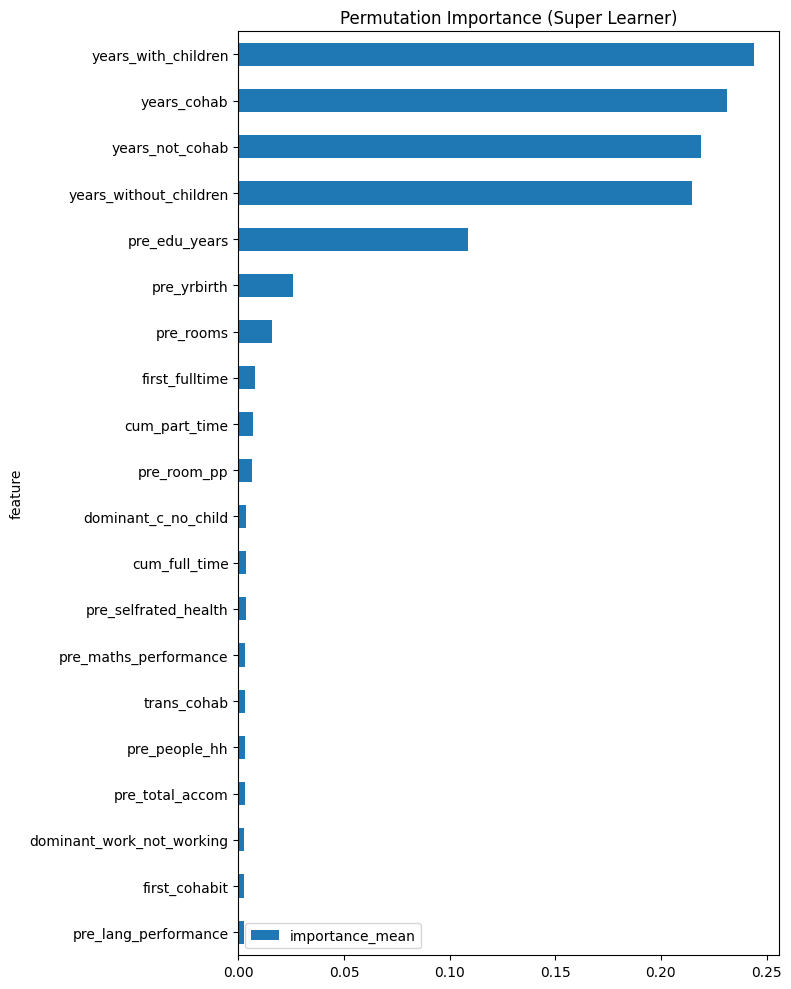

In [64]:
gc.plot_super_learner_permutation_importance(X = X_med_features_cogn_65_75_dic, 
                                             y = y_cogn_med_65_75_dic, 
                                             model = y_cogn_med_super_learner, 
                                             feature_names = trt_features_med_cogn_65_75_dic.columns.tolist(), 
                                             label = "cogn 65-75 (med)", output_dir="model_outputs/cogn/med")


=== Permutation Importance (Super Learner) ===
                   feature  importance_mean  importance_std
4      years_with_children         0.277277        0.017094
3          years_not_cohab         0.253497        0.009708
2              years_cohab         0.247383        0.012713
5   years_without_children         0.242452        0.011854
44           pre_edu_years         0.036584        0.001785
31             pre_yrbirth         0.032252        0.002086
40             pre_n_books         0.026335        0.003390
42   pre_maths_performance         0.024506        0.005436
43    pre_lang_performance         0.011703        0.001436
47              pre_dad_hs         0.010846        0.001676
0            cum_full_time         0.008383        0.001276
41         pre_total_accom         0.005761        0.000829
23   last_work_not_working         0.004816        0.001158
16          first_fulltime         0.004782        0.000442
30  dt_n_years_disease_dic         0.004727        0

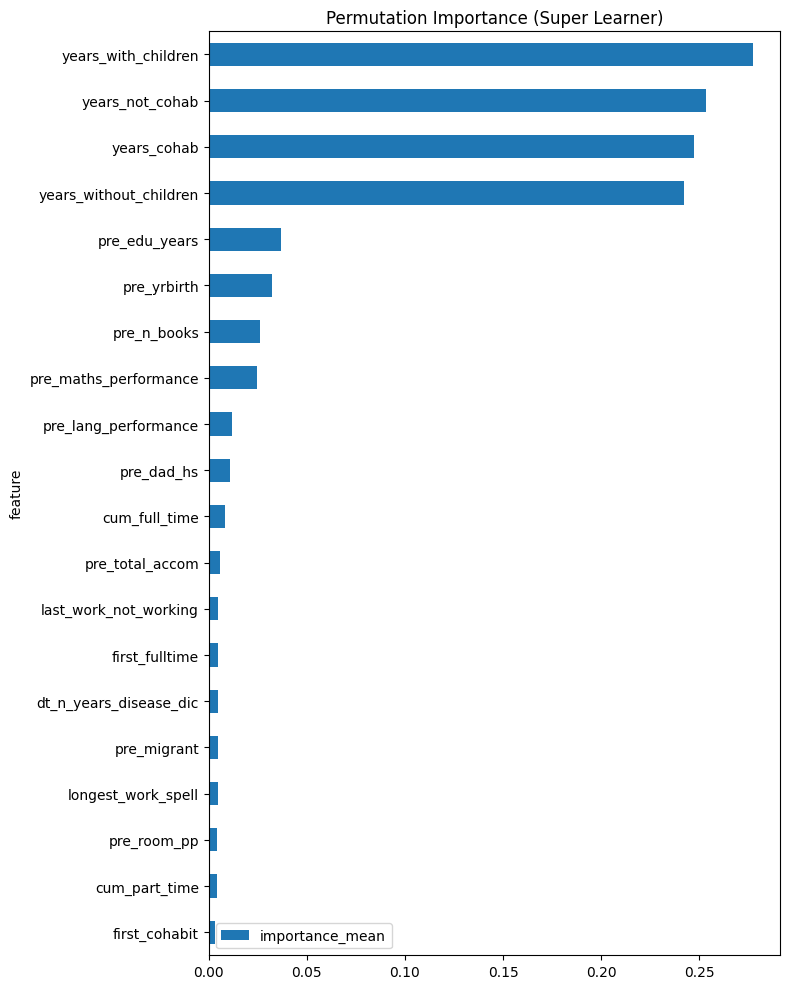

In [65]:
gc.plot_super_learner_permutation_importance(X = X_cor_features_cogn_65_75_dic, 
                                             y = y_cogn_cor_65_75_dic, 
                                             model = y_cogn_cor_super_learner, 
                                             feature_names = trt_features_cor_cogn_65_75_dic.columns.tolist(), 
                                             label = "cogn 65-75 (cor)", output_dir="model_outputs/cogn/cor")


=== Permutation Importance (Super Learner) ===
                      feature  importance_mean  importance_std
5      years_without_children         0.086139        0.013448
3             years_not_cohab         0.072219        0.014448
2                 years_cohab         0.067238        0.014600
4         years_with_children         0.065499        0.012855
42      pre_maths_performance         0.011651        0.006544
9   dominant_work_not_working         0.010109        0.002509
7     dominant_work_part_time         0.008556        0.004434
14                 trans_work         0.006694        0.005354
27    last_cohab_c_with_child         0.004802        0.003894
36               pre_hospital         0.003549        0.001181
26   last_cohab_nc_with_child         0.003529        0.002983
44              pre_edu_years         0.002992        0.007847
45                pre_migrant         0.002969        0.001106
25      last_cohab_c_no_child         0.002324        0.001653
12     

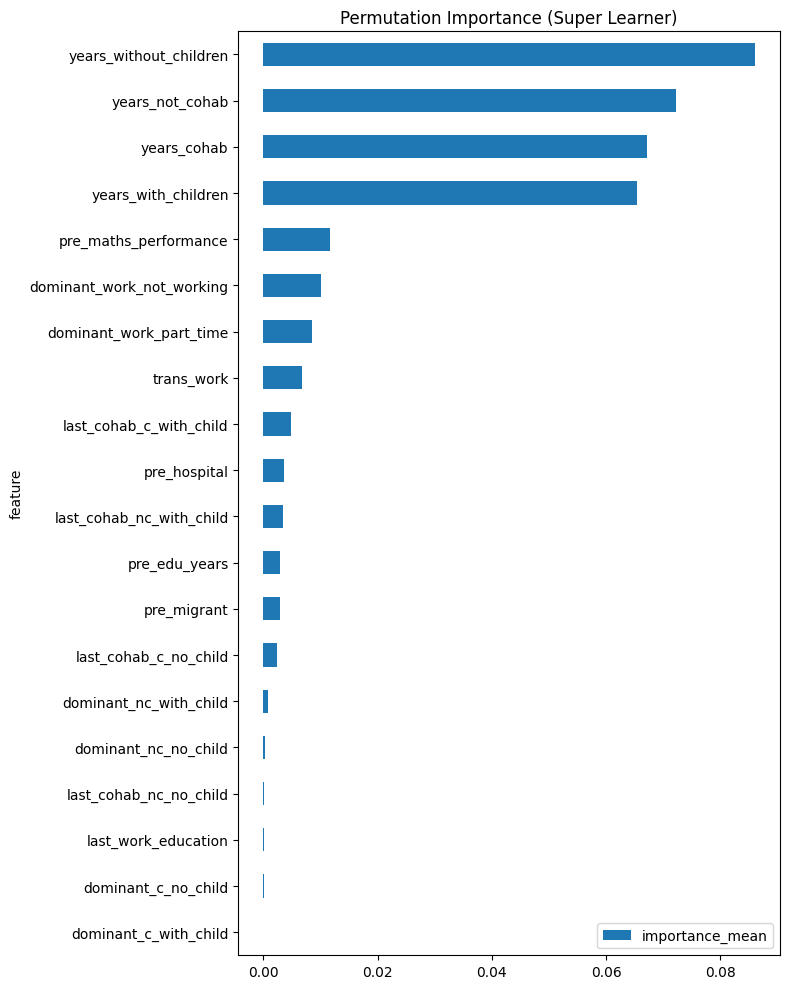

In [66]:
gc.plot_super_learner_permutation_importance(X = X_scan_features_cogn_65_75_dic, 
                                             y = y_cogn_scan_65_75_dic, 
                                             model = y_cogn_scan_super_learner, 
                                             feature_names = trt_features_scan_cogn_65_75_dic.columns.tolist(), 
                                             label = "cogn 65-75 (scan)", output_dir="model_outputs/cogn/scan")